# Previsione a 14 giorni

Previsione a 14 giorni con modello SARIMA.

> Max Pierini

***

I nuovi casi giornalieri osservati e previsti a 14 giorni sono stimati utilizzando un modello di autoregressione $\mathrm{SARIMA}(p,d,q)(P,D,Q,s)$, i cui parametri ottimali sono stati determinati per [grid-search](https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b) sul prodotto cartesiano di range empirici, scegliendo la combinazione di parametri che [minimizzi](https://machinelearningmastery.com/probabilistic-model-selection-measures/) il Bayesian Information Criterion ([BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)).

In modello migliore è attualmente

$$
\mathrm{SARIMA}(0, 1, 6)(0, 1, 10, 7)
$$

con BIC = $5269.954$. I parametri potrebbero essere ulteriormente affinati con successive grid-search mirate.

In [1]:
import numpy as np
import pandas as pd
import itertools
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)

In [3]:
df.index = df.index.normalize()

In [4]:
#df.index = df.index.to_period('D')

In [5]:
### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M', print_res=False):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in tqdm(pdq, leave=False):
        for combs in tqdm(pdqs, leave=False):
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                if print_res:
                    print('SARIMAX {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

In [6]:
_ = """
# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

# Remember to change frequency to match your time series data
ans_df = sarimax_gridsearch(df.nuovi_positivi, pdq, pdqs, freq='D')"""

In [7]:
df.index.name = None

In [8]:
# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(df.nuovi_positivi, 
                                    order=(0,1,6), 
                                    seasonal_order=(0,1,10,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
                                    
# Fit the model
sarimax_fit = sarimax.fit()

In [9]:
forecast = sarimax_fit.forecast()

predict_past = sarimax_fit.predict()

predict_future = sarimax_fit.predict(start=df.index[-1], end=df.index[-1] + pd.Timedelta(days=14))

# Previsione

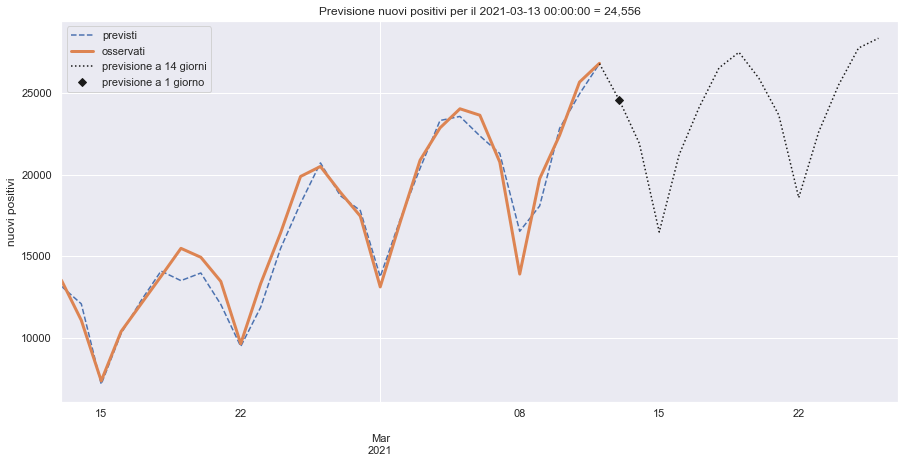

In [10]:
ax = predict_past.iloc[-28:].plot(label='previsti', ls='--', figsize=(15, 7))
df.iloc[-28:].nuovi_positivi.plot(ax=ax, lw=3, label='osservati')
predict_future.plot(ax=ax, color='k', ls=':', label='previsione a 14 giorni')
ax.plot(forecast, marker='D', ls='none', color='k', label="previsione a 1 giorno")
ax.set_xlim(ax.get_xlim()[0], predict_future.index[-1]+pd.Timedelta(days=1))
ax.set(
    title=f'Previsione nuovi positivi per il {forecast.index[0]} = {forecast.values[0]:,.0f}',
    ylabel='nuovi positivi'
)
ax.legend()
plt.show()

# Diagnostica

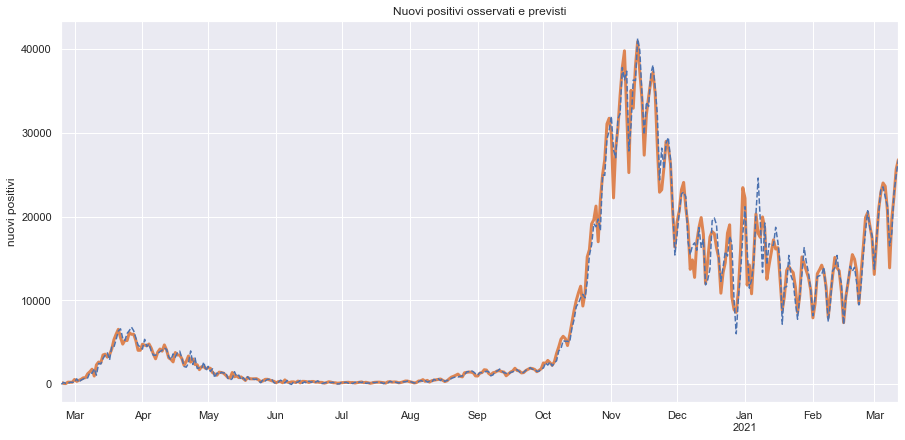

In [11]:
ax = predict_past.plot(
    figsize=(15, 7), title='Nuovi positivi osservati e previsti',
    ls='--', zorder=100,
    ylabel='nuovi positivi'
)
df.nuovi_positivi.plot(ax=ax, lw=3)
plt.show()

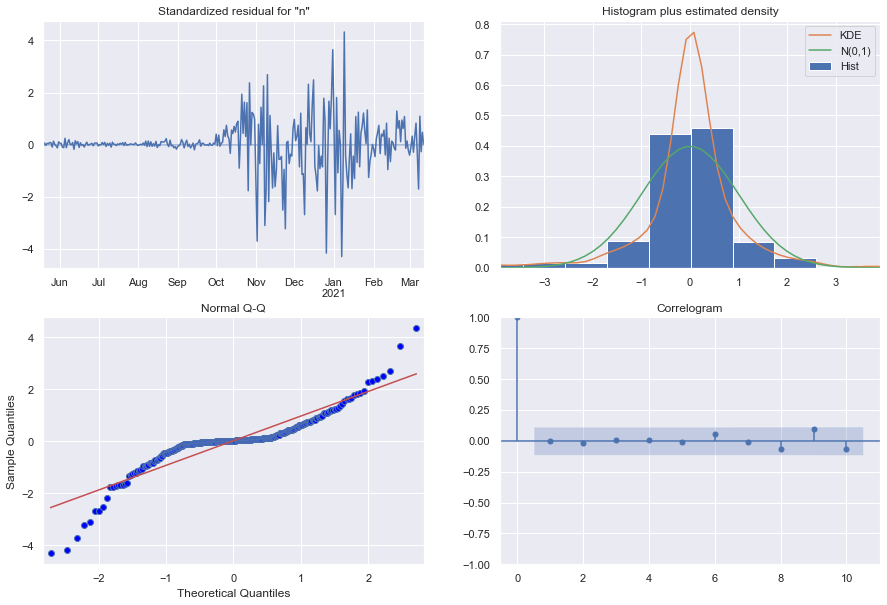

In [12]:
# Plot diagnostics
sarimax_fit.plot_diagnostics(figsize=(15,10));

In [13]:
# Print output summary
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                    SARIMAX Results                                                    
=======================================================================================================================
Dep. Variable:                                                  nuovi_positivi   No. Observations:                  383
Model:             SARIMAX(0, 1, 6)x(0, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 7)   Log Likelihood               -2594.792
Date:                                                         Fri, 12 Mar 2021   AIC                           5223.584
Time:                                                                 18:03:39   BIC                           5286.434
Sample:                                                             02-24-2020   HQIC                          5248.742
                                                                  - 03-12-2021                                         
Covariance Type:                                                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2133      0.053     -4.058      0.000      -0.316      -0.110
ma.L2         -0.2272      0.046     -4.908      0.000      -0.318      -0.136
ma.L3          0.0519      0.048      1.092      0.275      -0.041       0.145
ma.L4         -0.1358      0.055     -2.468      0.014      -0.244      -0.028
ma.L5          0.1398      0.048      2.925      0.003       0.046       0.233
ma.L6          0.1967      0.052      3.791      0.000       0.095       0.298
ma.S.L7       -0.4287      0.041    -10.400      0.000      -0.510      -0.348
ma.S.L14      -0.2140      0.057     -3.774      0.000      -0.325      -0.103
ma.S.L21      -0.0899      0.064     -1.415      0.157      -0.214       0.035
ma.S.L28       0.0368      0.069      0.536      0.592      -0.098       0.171
ma.S.L35      -0.0640      0.080     -0.797      0.425      -0.221       0.093
ma.S.L42      -0.0608      0.084     -0.721      0.471      -0.226       0.104
ma.S.L49      -0.0495      0.065     -0.758      0.448      -0.177       0.078
ma.S.L56       0.0711      0.093      0.767      0.443      -0.111       0.253
ma.S.L63      -0.0122      0.110     -0.112      0.911      -0.227       0.203
ma.S.L70       0.0508      0.105      0.483      0.629      -0.155       0.257
sigma2      2.353e+06   1.34e+05     17.577      0.000    2.09e+06    2.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               436.18
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             258.06   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""